In [5]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [6]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [7]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [9]:
import pickle
from pathlib import Path

base = Path.cwd()          # this is week8 folder
week6 = base.parent / "week6"

with open(week6 / "train_lite.pkl", "rb") as file:
    train = pickle.load(file)

with open(week6 / "test_lite.pkl", "rb") as file:
    test = pickle.load(file)

In [10]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [11]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [12]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [14]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [15]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [16]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [17]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [18]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $93.38 Truth: $65.99 Error: $27.39 SLE: 0.12 Item: Setpower Insulated Protective Cover for ...
2: Guess: $176.15 Truth: $9.68 Error: $166.47 SLE: 7.89 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $195.76 Truth: $155.98 Error: $39.78 SLE: 0.05 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $39.62 Truth: $5.59 Error: $34.03 SLE: 3.31 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $107.93 Truth: $98.40 Error: $9.53 SLE: 0.01 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $39.71 Truth: $54.99 Error: $15.28 SLE: 0.10 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $55.50 Truth: $5.71 Error: $49.79 SLE: 4.54 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $34.02 Truth: $9.53 Error: $24.49 SLE: 1.44 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $21.41 Truth: $11.24 Error: $10.17 SLE: 0.37 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $27.29 Truth: $12.88 Error: $14.41 SLE: 0.51 Item: Away 

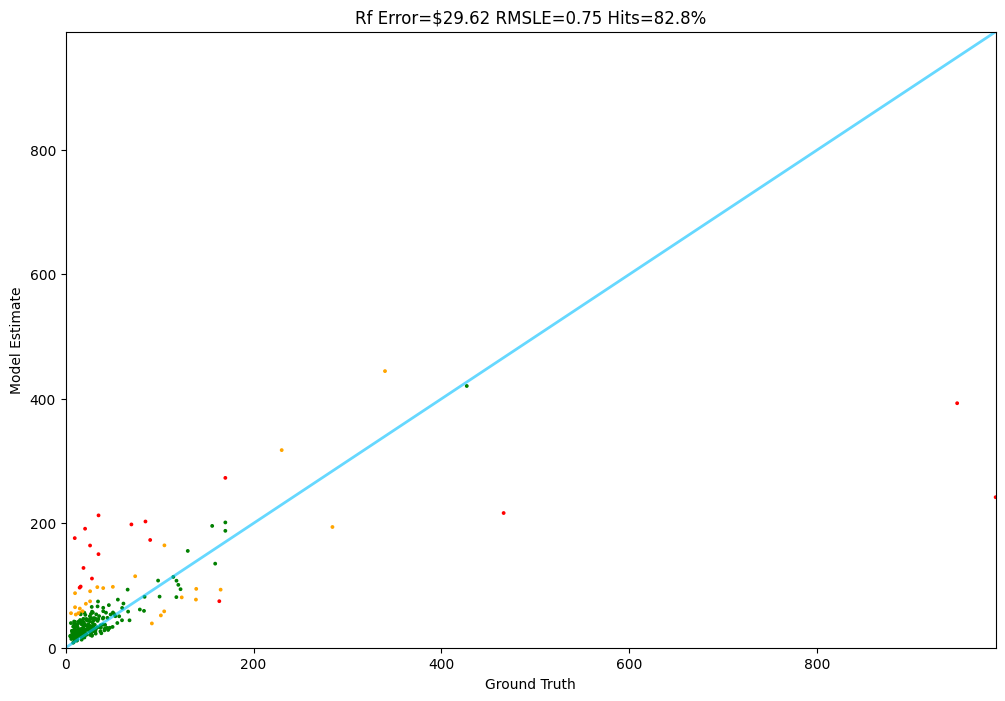

In [19]:
Tester.test(rf, test)

In [20]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"